### Recycling Robot


In [1]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, Tuple, List
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ---------------- Config ----------------
GAMMA = 0.95               # Discount factor 
TD_LR = 0.1                # Learning rate for TD    
EPOCHS = 50                # Number of independent training cycles
STEPS_PER_EPOCH = 1000     # Steps per epoch per training cycle
NUM_RUNS = 100             # Multiple trainings to average curves
EPSILON = 0.1              # Probability of exploring random actions

# ---------------- Scenario grids ----------------
R_SEARCH_GRID  = [5, 8, 10]           # Reward for finding a can
R_WAIT_GRID    = [1, 2, 3]           # Reward for waiting
RESCUE_PENALTY = -3          # Penalty for being rescued
ALPHA_GRID = [0.3, 0.6, 0.9] # Risky searching, Moderate, Very Safe (Probability that the battery stay High after a Search)
BETA_GRID =  [0.3, 0.6, 0.9] # Dangerous to search, Moderate, Very Safe (Probability that the battery stay Low after a Search)

# --------------- Environment ---------------
STATE_H, STATE_L = 0, 1
A_SEARCH, A_WAIT, A_RECHARGE = 0, 1, 2
STATE_NAMES = ["high", "low"]
ACTION_NAMES = ["search", "wait", "recharge"]
START_STATE = 0            
BASE_SEED = 2025

# --------------- Output Files ---------------
REWARDS_PATH       = "rewards.txt"           
REWARDS_FIG        = "accumulated_reward.png"
POLICY_HEATMAP_FIG = "optimal_policy_heatmap.png"

In [3]:
@dataclass
class Params:
    alpha: float
    beta: float
    r_search: int
    r_wait: int
    gamma: float
    rescue_penalty: int

def valid_actions(state: int) -> List[int]: return [A_SEARCH, A_WAIT] if state == STATE_H else [A_SEARCH, A_WAIT, A_RECHARGE]

def step_env(rng: np.random.Generator, state: int, action: int, p: Params) -> Tuple[int, float]:
    if state == STATE_H:
        if action == A_SEARCH:
            reward = p.r_search
            state_next = STATE_H if rng.random() < p.alpha else STATE_L
            return state_next, reward
        elif action == A_WAIT:
            return STATE_H, p.r_wait
    else:
        if action == A_SEARCH:
            if rng.random() < p.beta:
                return STATE_L, p.r_search
            else:
                return STATE_H, p.rescue_penalty
        elif action == A_WAIT:
            return STATE_L, p.r_wait
        elif action == A_RECHARGE:
            return STATE_H, 0.0

def choose_action(rng: np.random.Generator, state: int, V: np.ndarray, p: Params, epsilon: float) -> int:
    valid = valid_actions(state)
    if rng.random() < epsilon: return rng.choice(valid)

    q_values = []
    for action in valid:
        if state == STATE_H: 
            if action == A_SEARCH:
                q = p.r_search + p.gamma * (p.alpha * V[STATE_H] + (1 - p.alpha) * V[STATE_L])
            elif action == A_WAIT:
                q = p.r_wait + p.gamma * V[STATE_H]
        else:            
            if action == A_SEARCH:
                q = p.beta * (p.r_search + p.gamma * V[STATE_L]) \
                  + (1 - p.beta) * (p.rescue_penalty + p.gamma * V[STATE_H])
            elif action == A_WAIT:
                q = p.r_wait + p.gamma * V[STATE_L]
            elif action == A_RECHARGE:
                q = 0.0 + p.gamma * V[STATE_H]
        q_values.append(q)

    best_idx = int(np.argmax(q_values))
    return valid[best_idx]

def td_update(V: np.ndarray, state: int, r: float, state_next: int, p: Params, lr: float) -> None:
    V[state] += lr * (r + p.gamma * V[state_next] - V[state])

def train_td(rng: np.random.Generator, p: Params, epochs: int, steps_per_epoch: int, lr: float, epsilon: float) -> np.ndarray:
    Value_States = np.zeros(2)     

    for ep in range(epochs):
        state = STATE_H
        for _ in range(steps_per_epoch):
            action             = choose_action(rng, state, Value_States, p, epsilon)
            state_next, reward = step_env(rng, state, action, p)
            td_update(Value_States, state, reward, state_next, p, lr)
            state = state_next
    return Value_States

In [4]:
def rewards_average(p: Params, num_runs: int, epochs: int, steps_per_epoch: int,
lr: float, epsilon: float, seed: int = BASE_SEED) -> np.ndarray:

    rewards_all = np.zeros((num_runs, epochs))
    for run in range(num_runs):
        rng = np.random.default_rng(seed + run)
        V = np.zeros(2)  

        for ep in range(epochs):
            state = STATE_H
            total_reward = 0.0

            for _ in range(steps_per_epoch):
                action             = choose_action(rng, state, V, p, epsilon)
                state_next, reward = step_env(rng, state, action, p)
                td_update(V, state, reward, state_next, p, lr)
                total_reward += reward
                state = state_next

            rewards_all[run, ep] = total_reward

    rewards_avg = rewards_all.mean(axis=0)
    np.savetxt(REWARDS_PATH, rewards_avg, fmt="%.4f")
    return rewards_avg, V

### Validation Stage

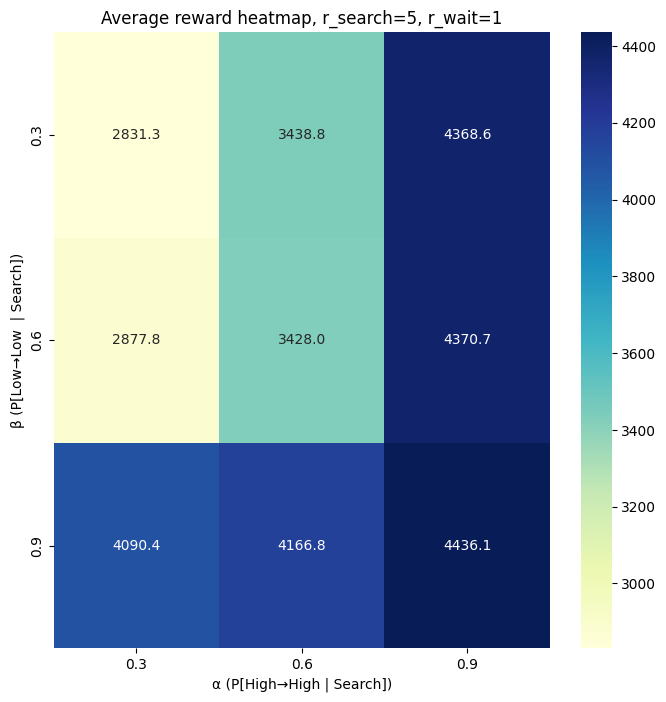

In [ ]:
results = []
for beta in BETA_GRID:
    for alpha in ALPHA_GRID:
        p = Params(alpha=alpha, beta=beta,
                   gamma=GAMMA, 
                   rescue_penalty=RESCUE_PENALTY,
                   r_search=R_SEARCH_GRID[0],
                   r_wait=R_WAIT_GRID[0])    
        rewards_avg, V = rewards_average(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)
        results.append({"alpha": alpha, "beta": beta, "reward": float(rewards_avg.mean())})

df = pd.DataFrame(results)
reward_matrix = df.pivot(index="beta", columns="alpha", values="reward")
plt.figure(figsize=(8,8))
sns.heatmap(reward_matrix, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title(f"Average reward heatmap, r_search={R_SEARCH_GRID[0]}, r_wait={R_WAIT_GRID[0]}")
plt.xlabel("α (P[High→High | Search])")
plt.ylabel("β (P[Low→Low  | Search])")
plt.show(); plt.close()

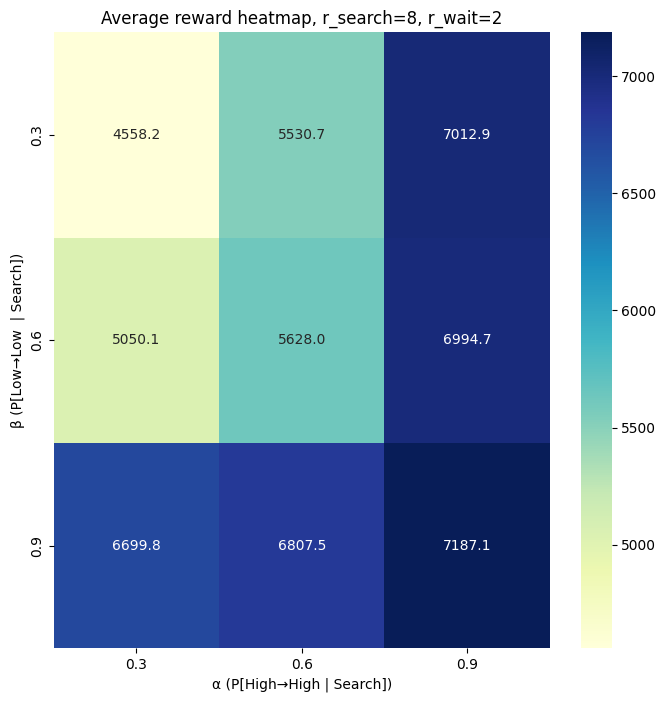

In [ ]:
results = []
for beta in BETA_GRID:
    for alpha in ALPHA_GRID:
        p = Params(alpha=alpha, beta=beta,
                   gamma=GAMMA, 
                   rescue_penalty=RESCUE_PENALTY,
                   r_search=R_SEARCH_GRID[1],
                   r_wait=R_WAIT_GRID[1])    
        rewards_avg, V = rewards_average(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)
        results.append({"alpha": alpha, "beta": beta, "reward": float(rewards_avg.mean())})

df = pd.DataFrame(results)
reward_matrix = df.pivot(index="beta", columns="alpha", values="reward")
plt.figure(figsize=(8,8))
sns.heatmap(reward_matrix, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title(f"Average reward heatmap, r_search={R_SEARCH_GRID[1]}, r_wait={R_WAIT_GRID[1]}")
plt.xlabel("α (P[High→High | Search])")
plt.ylabel("β (P[Low→Low  | Search])")
plt.show(); plt.close()

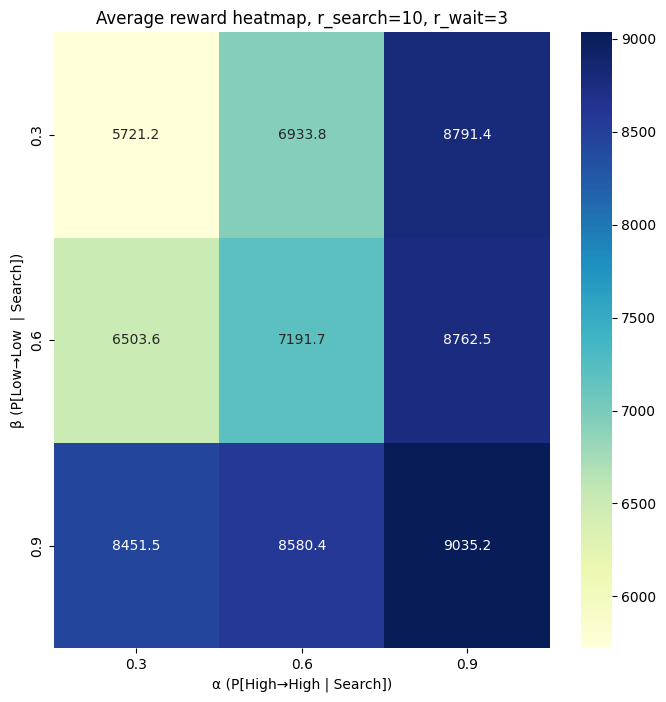

In [ ]:
results = []
for beta in BETA_GRID:
    for alpha in ALPHA_GRID:
        p = Params(alpha=alpha, beta=beta,
                   gamma=GAMMA, 
                   rescue_penalty=RESCUE_PENALTY,
                   r_search=R_SEARCH_GRID[2],
                   r_wait=R_WAIT_GRID[2])    
        rewards_avg, V = rewards_average(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)
        results.append({"alpha": alpha, "beta": beta, "reward": float(rewards_avg.mean())})

df = pd.DataFrame(results)
reward_matrix = df.pivot(index="beta", columns="alpha", values="reward")
plt.figure(figsize=(8,8))
sns.heatmap(reward_matrix, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title(f"Average reward heatmap, r_search={R_SEARCH_GRID[2]}, r_wait={R_WAIT_GRID[2]}")
plt.xlabel("α (P[High→High | Search])")
plt.ylabel("β (P[Low→Low  | Search])")
plt.show(); plt.close()

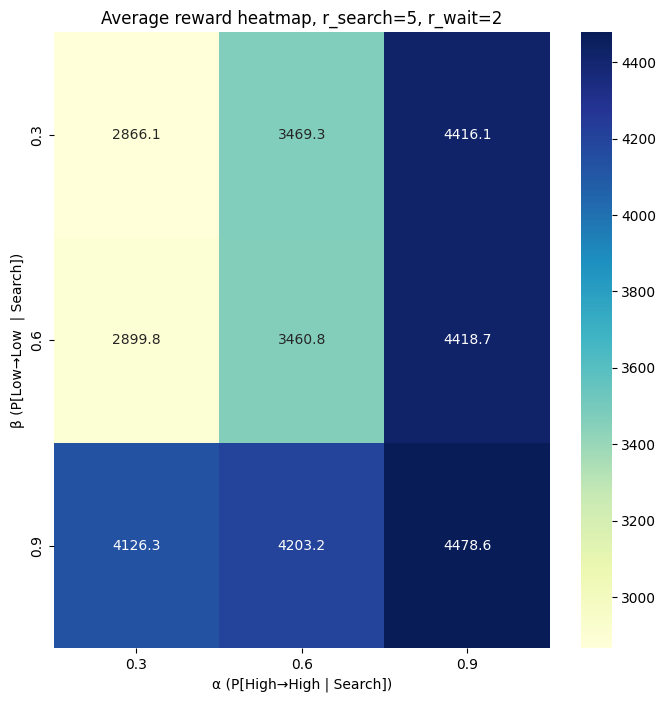

In [10]:
results = []
for beta in BETA_GRID:
    for alpha in ALPHA_GRID:
        p = Params(alpha=alpha, beta=beta,
                   gamma=GAMMA, 
                   rescue_penalty=RESCUE_PENALTY,
                   r_search=R_SEARCH_GRID[0],
                   r_wait=R_WAIT_GRID[1])    
        rewards_avg, V = rewards_average(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)
        results.append({"alpha": alpha, "beta": beta, "reward": float(rewards_avg.mean())})

df = pd.DataFrame(results)
reward_matrix = df.pivot(index="beta", columns="alpha", values="reward")
plt.figure(figsize=(8,8))
sns.heatmap(reward_matrix, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title(f"Average reward heatmap, r_search={R_SEARCH_GRID[0]}, r_wait={R_WAIT_GRID[1]}")
plt.xlabel("α (P[High→High | Search])")
plt.ylabel("β (P[Low→Low  | Search])")
plt.show(); plt.close()

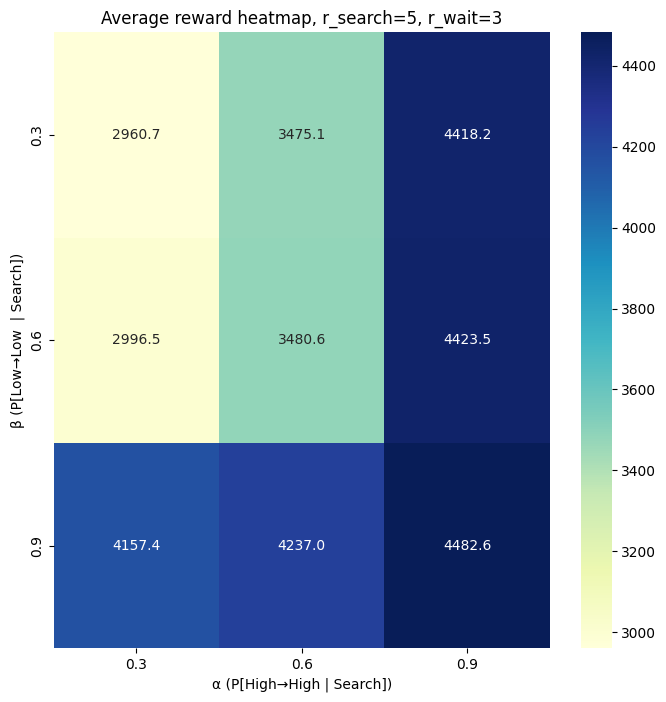

In [11]:
results = []
for beta in BETA_GRID:
    for alpha in ALPHA_GRID:
        p = Params(alpha=alpha, beta=beta,
                   gamma=GAMMA, 
                   rescue_penalty=RESCUE_PENALTY,
                   r_search=R_SEARCH_GRID[0],
                   r_wait=R_WAIT_GRID[2])    
        rewards_avg, V = rewards_average(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)
        results.append({"alpha": alpha, "beta": beta, "reward": float(rewards_avg.mean())})

df = pd.DataFrame(results)
reward_matrix = df.pivot(index="beta", columns="alpha", values="reward")
plt.figure(figsize=(8,8))
sns.heatmap(reward_matrix, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title(f"Average reward heatmap, r_search={R_SEARCH_GRID[0]}, r_wait={R_WAIT_GRID[2]}")
plt.xlabel("α (P[High→High | Search])")
plt.ylabel("β (P[Low→Low  | Search])")
plt.show(); plt.close()

### Testing Stage

In [12]:
def plot_rewards_curve(rewards_avg: np.ndarray):
    plt.figure(figsize=(8,5))
    plt.plot(rewards_avg, label="Average total reward")
    plt.xlabel("Epoch")
    plt.ylabel("Accumulated reward")
    plt.title("Recycling Robot – Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig(REWARDS_FIG, dpi=300)
    # plt.close()

def plot_policy_heatmap(V: np.ndarray, p: Params):
    policy = {}
    for s in [STATE_H, STATE_L]:
        valid = valid_actions(s)
        qvals = [0.0] * len(ACTION_NAMES)
        for a in valid:
            if s == STATE_H:
                if a == A_SEARCH:
                    qvals[a] = p.r_search + p.gamma * (p.alpha * V[STATE_H] + (1 - p.alpha) * V[STATE_L])
                elif a == A_WAIT:
                    qvals[a] = p.r_wait + p.gamma * V[STATE_H]
            else:  # state = LOW
                if a == A_SEARCH:
                    qvals[a] = p.beta * (p.r_search + p.gamma * V[STATE_L]) \
                             + (1 - p.beta) * (p.rescue_penalty + p.gamma * V[STATE_H])
                elif a == A_WAIT:
                    qvals[a] = p.r_wait + p.gamma * V[STATE_L]
                elif a == A_RECHARGE:
                    qvals[a] = 0.0 + p.gamma * V[STATE_H]

        qvals = np.array(qvals)
        probs = np.exp(qvals - np.max(qvals))
        probs /= probs.sum()
        policy[s] = probs

    heatmap_data = np.zeros((len(STATE_NAMES), len(ACTION_NAMES)))
    for s in policy: heatmap_data[s, :] = policy[s]

    plt.figure(figsize=(6,3))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", xticklabels=ACTION_NAMES, yticklabels=STATE_NAMES, cmap="Blues")
    plt.title("Optimal Policy (action probabilities)")
    plt.savefig(POLICY_HEATMAP_FIG, dpi=300)
    # plt.close()

Training complete. Results saved to:
- Rewards file: rewards.txt
- Rewards plot: accumulated_reward.png
- Policy heatmap: optimal_policy_heatmap.png


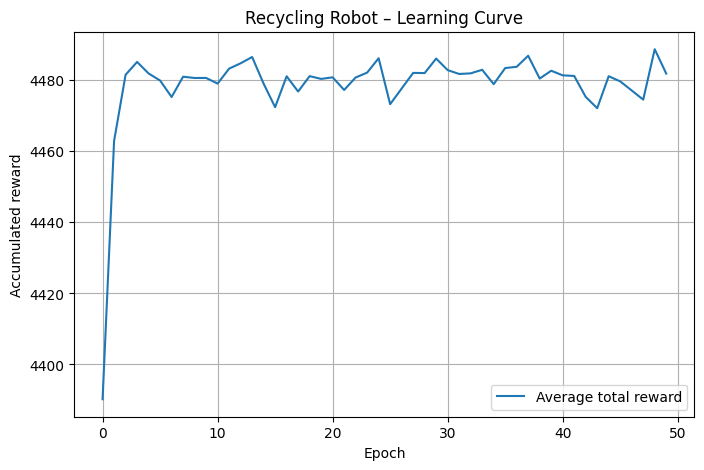

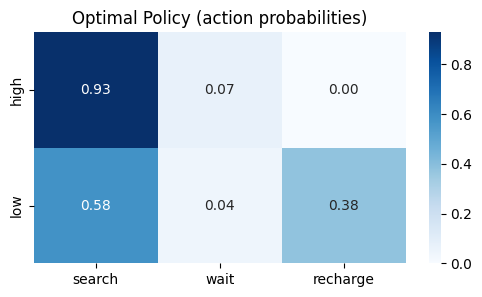

In [13]:
# ---------------- Scenario grids ----------------
R_SEARCH  = 5           # Reward for finding a can
R_WAIT    = 2           # Reward for waiting
RESCUE_PENALTY = -3          # Penalty for being rescued
ALPHA = 0.9 
BETA =  0.9

if __name__ == "__main__":
    p = Params(alpha=ALPHA,
               beta=BETA,
               r_search=R_SEARCH,
               r_wait=R_WAIT,
               gamma=GAMMA,
               rescue_penalty=RESCUE_PENALTY)

    rewards_avg, V = rewards_average(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)
    plot_rewards_curve(rewards_avg)
    plot_policy_heatmap(V, p)

    print("Training complete. Results saved to:")
    print(f"- Rewards file: {REWARDS_PATH}")
    print(f"- Rewards plot: {REWARDS_FIG}")
    print(f"- Policy heatmap: {POLICY_HEATMAP_FIG}")

Training complete. Results saved to:
- Rewards file: rewards.txt
- Rewards plot: accumulated_reward.png
- Policy heatmap: optimal_policy_heatmap.png


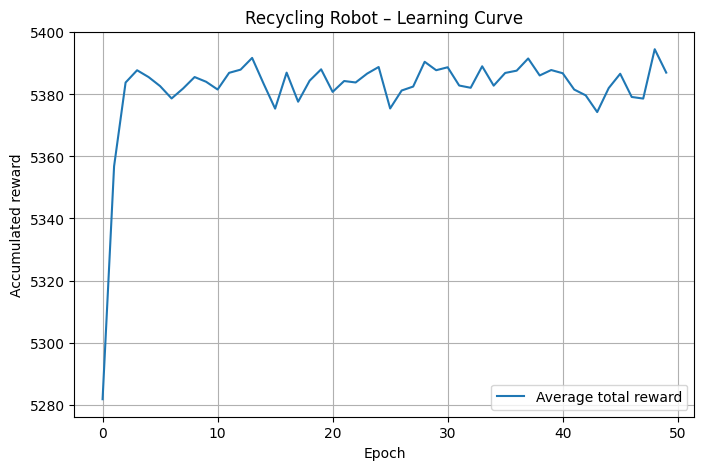

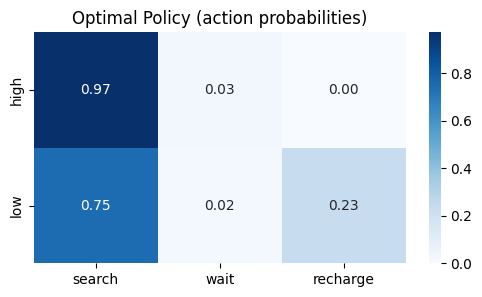

In [14]:
# ---------------- Scenario grids ----------------
R_SEARCH  = 6           # Reward for finding a can
R_WAIT    = 2           # Reward for waiting
RESCUE_PENALTY = -3          # Penalty for being rescued
ALPHA = 0.9 
BETA =  0.9

if __name__ == "__main__":
    p = Params(alpha=ALPHA,
               beta=BETA,
               r_search=R_SEARCH,
               r_wait=R_WAIT,
               gamma=GAMMA,
               rescue_penalty=RESCUE_PENALTY)

    rewards_avg, V = rewards_average(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)
    plot_rewards_curve(rewards_avg)
    plot_policy_heatmap(V, p)

    print("Training complete. Results saved to:")
    print(f"- Rewards file: {REWARDS_PATH}")
    print(f"- Rewards plot: {REWARDS_FIG}")
    print(f"- Policy heatmap: {POLICY_HEATMAP_FIG}")

Training complete. Results saved to:
- Rewards file: rewards.txt
- Rewards plot: accumulated_reward.png
- Policy heatmap: optimal_policy_heatmap.png


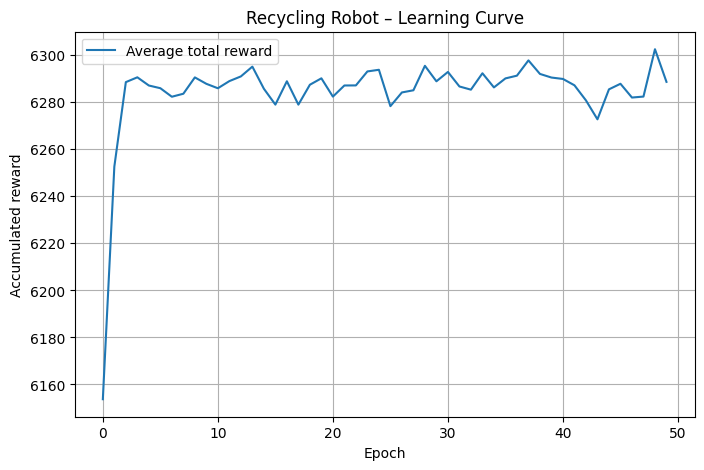

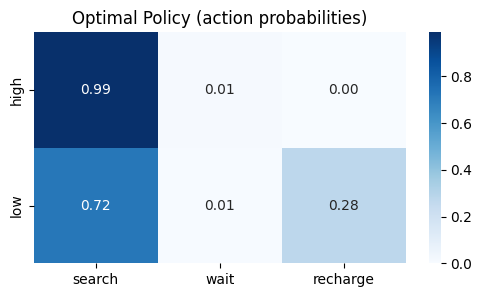

In [15]:
# ---------------- Scenario grids ----------------
R_SEARCH  = 7           # Reward for finding a can
R_WAIT    = 2           # Reward for waiting
RESCUE_PENALTY = -3          # Penalty for being rescued
ALPHA = 0.9 
BETA =  0.9

if __name__ == "__main__":
    p = Params(alpha=ALPHA,
               beta=BETA,
               r_search=R_SEARCH,
               r_wait=R_WAIT,
               gamma=GAMMA,
               rescue_penalty=RESCUE_PENALTY)

    rewards_avg, V = rewards_average(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)
    plot_rewards_curve(rewards_avg)
    plot_policy_heatmap(V, p)

    print("Training complete. Results saved to:")
    print(f"- Rewards file: {REWARDS_PATH}")
    print(f"- Rewards plot: {REWARDS_FIG}")
    print(f"- Policy heatmap: {POLICY_HEATMAP_FIG}")

Training complete. Results saved to:
- Rewards file: rewards.txt
- Rewards plot: accumulated_reward.png
- Policy heatmap: optimal_policy_heatmap.png


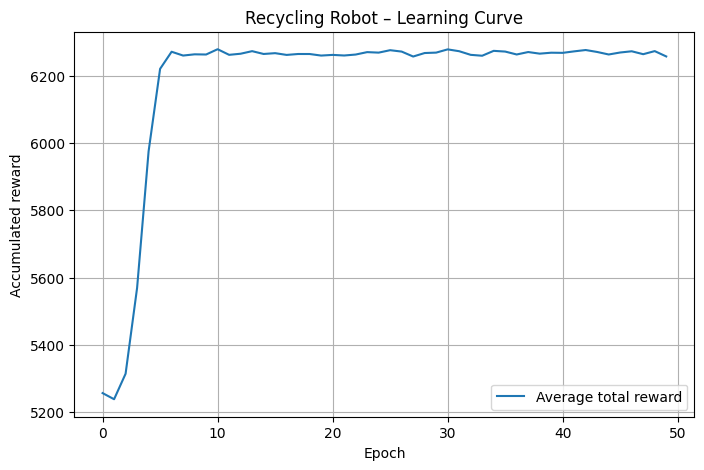

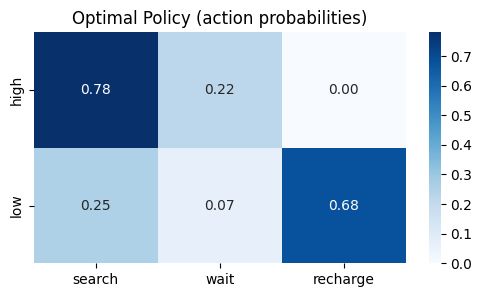

In [17]:
# ---------------- Scenario grids ----------------
R_SEARCH  = 7           # Reward for finding a can
R_WAIT    = 5           # Reward for waiting
RESCUE_PENALTY = -7          # Penalty for being rescued
ALPHA = 0.9 
BETA =  0.9

if __name__ == "__main__":
    p = Params(alpha=ALPHA,
               beta=BETA,
               r_search=R_SEARCH,
               r_wait=R_WAIT,
               gamma=GAMMA,
               rescue_penalty=RESCUE_PENALTY)

    rewards_avg, V = rewards_average(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)
    plot_rewards_curve(rewards_avg)
    plot_policy_heatmap(V, p)

    print("Training complete. Results saved to:")
    print(f"- Rewards file: {REWARDS_PATH}")
    print(f"- Rewards plot: {REWARDS_FIG}")
    print(f"- Policy heatmap: {POLICY_HEATMAP_FIG}")